# Task Prioritization Using Reinforcement Learning
### Maddy Lorrigan

My goal is to find the best way to train an RL agent to prioritize tasks and complete them all in a specific order, similar to how a college student needs to be able to prioritize tasks that they have to do in a day/week/semester.

My initial scenario looks like the following:
* 10 tasks
* 6 steps per episode
* Penalties for not finishing certain tasks by the end
* Reward decays over time
* Starting energy between 30-35
* Agent gets penalized for picking a task that is already done, but then gets to try again.
* Agent can randomly “get distracted” which causes it to lose a random amount of energy [1:5]
* Higher chance of getting distracted when switching between unrelated tasks
* Episode ends early when energy drops below zero.

STATE = (energy_left, current_category, tasks_done (represented as an integer), time_left)

In [63]:
#Example of tasks
import pandas as pd
tasks = pd.read_csv('tasks.csv.csv')
tasks

,Task Description,Category,Value,Difficulty,Energy Cost,Penalty
0,Dishes,Chores,4,3,4,-3.00
1,Laundry,Chores,6,1,2,-1.50
2,RL Homework,CS,8,7,12,-14.00
3,DL Lab,CS,10,10,20,-25.00
4,Reading,Leisure,1,0,1,0.00
5,Doomscrolling,Leisure,0,0,1,0.00
6,Religion Reading,Religion,3,2,3,-1.50
7,Sleeping,Rest,0,-7,-10,0.00
8,Stats Homework,Stats,7,5,8,-8.75
9,Research,Work,5,6,10,-7.50


This project involved a variety of classes. We'll start with creating a Tasks class, a SARSA Table class, a Q Table class and an Environment class.

In [64]:
class Task():
    def __init__(self, name, category, value, energy_cost, penalty):
        self.name = name
        self.category = category
        self.value = int(value)
        self.energy_cost = int(energy_cost)
        self.penalty = float(penalty)

    def updateValue(self):
        self.value *= .95

    def normalizeValueAndPenalty(self, norm):
        self.value /= norm
        self.penalty /= norm

    def __str__(self):
        return f"{self.name} has a value of {self.value} and a cost of {self.energy_cost}."

In [65]:
import random

class Environment():
    def __init__(self, startEnergyMin=30, startEnergyMax=35, timePerEp = 6, tasksCsv = 'tasks.csv.csv'):
        #Creating all of my tasks
        self.tasksList = []
        norm = None
        with open(tasksCsv, 'r') as file:
            headers = file.readline()
            for line in file.readlines():
                elements = line.strip().split(',')
                self.tasksList.append(Task(elements[0], elements[1], elements[2], elements[4], elements[5]))
                if norm is None or abs(int(elements[2])) > norm:
                    norm = abs(int(elements[2]))
                if abs(float(elements[5])) > norm:
                    norm = abs(float(elements[5]))

        self.tasksDone = [0 for i in range(len(self.tasksList))]
        self.energy = random.randint(startEnergyMin,startEnergyMax)
        self.distractionProbs = {'low':.1, 'medium':.25, 'high':.5}
        self.time_left = timePerEp

        self.categoriesList = []
        for task in self.tasksList:
            task.normalizeValueAndPenalty(norm)
            if task.category not in self.categoriesList:
                self.categoriesList.append(task.category)

        self.currentCat = 'Rest'

    def updateAction(self, action, dqn = False):
        if self.time_left == 0:
            # print("We're done!")
            return None, None

        if self.tasksDone[action] == 1:
            # print('This task has already been done!')
            if not dqn:
                return -1, (self.energy, self.currentCat, self.todosToBits(), self.time_left)
            else:
                return -1, [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left], 0

        completedTask = self.tasksList[action]

        if self.currentCat == None or self.currentCat == 'Rest':
            risk = -1
        elif self.currentCat == completedTask.category:
            risk = self.distractionProbs['low']
        elif self.currentCat in ['CS','Stats','Work'] and completedTask.category in ['CS','Stats','Work']:
            risk = self.distractionProbs['medium']
        elif self.currentCat in ['Chores', 'Religion'] and completedTask.category in ['Chores', 'Religion']:
            risk = self.distractionProbs['medium']
        else:
            risk = self.distractionProbs['high']

        if self.energy - completedTask.energy_cost < 0:
            # print("You don't have enough energy for this task!")
            self.energy = 0
            self.time_left = 0
            penalities = self.getEndPenalties()
            if not dqn:
                return -1 + penalities, None
            else:
                return -1 + penalities, [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left], 1


        self.energy -= completedTask.energy_cost
        distractionNoise = random.randint(1,5)
        if random.uniform(0,1) <= risk:
            self.energy = max(self.energy - distractionNoise, 0)

        self.currentCat = completedTask.category
        self.tasksDone[action] = 1
        for i in range(len(self.tasksList)):
            if self.tasksDone[i] == 0:
                self.tasksList[i].updateValue()
        self.time_left -= 1


        if self.time_left == 0:
            if not dqn:
                return self.getEndPenalties() + completedTask.value, None
            else:
                return self.getEndPenalties() + completedTask.value, [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left], 1
        else:
            if not dqn:
                return completedTask.value, (self.energy, self.currentCat, self.todosToBits(), self.time_left)
            else:
                return completedTask.value, [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left], 0


    def todosToBits(self):
        bitmask = int("".join(map(str, self.tasksDone)), 2)
        return bitmask

    def getEndPenalties(self):
        pen = 0
        for i in range(len(self.tasksDone)):
            if self.tasksDone[i] == 0:
                pen += self.tasksList[i].penalty
        return pen

    def getStartState(self, dqn = False):
        if not dqn:
            return (self.energy, self.currentCat, self.todosToBits(), self.time_left)
        else:
            return [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left]

    def setEnergy(self, energy):
        self.energy = energy




In [66]:
import random

class SARSATable:
    def __init__(self, num_actions, alpha=0.1, gamma=0.99):
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.table = {}
        self.visits = {}

    def ensure_state(self, state):
        if state not in self.table:
            self.table[state] = [0.0] * self.num_actions
            self.visits[state] = 0

    def get_s(self, state, action):
        self.ensure_state(state)
        return self.table[state][action]

    def set_s(self, state, action, value):
        self.ensure_state(state)
        self.table[state][action] = value
        self.visits[state] += 1

    def choose_action(self, state, epsilon):
        self.ensure_state(state)

        # epsilon-greedy
        if random.random() < epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            return max(range(self.num_actions), key=lambda a: self.table[state][a])

    def update_sarsa(self, state, action, reward, next_state, next_action):
        self.ensure_state(state)
        self.ensure_state(next_state)

        old = self.table[state][action]
        delta = reward + self.gamma * self.table[next_state][next_action] - old
        self.table[state][action] = old + self.alpha * delta
        self.visits[state] += 1

    def update_terminal(self, state, action, reward):
        self.ensure_state(state)
        old = self.table[state][action]
        self.table[state][action] = old + self.alpha * (reward - old)
        self.visits[state] += 1


In [67]:
import random

class QTable:
    def __init__(self, num_actions, alpha=0.1, gamma=0.99):
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.table = {}
        self.visits = {}

    def ensure_state(self, state):
        if state not in self.table:
            self.table[state] = [0.0] * self.num_actions
            self.visits[state] = 0

    def get_q(self, state, action):
        self.ensure_state(state)
        return self.table[state][action]

    def set_q(self, state, action, value):
        self.ensure_state(state)
        self.table[state][action] = value
        self.visits[state] += 1

    def choose_action(self, state, epsilon):
        self.ensure_state(state)

        # epsilon-greedy
        if random.random() < epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            return max(range(self.num_actions), key=lambda a: self.table[state][a])

    def update_q(self, state, action, reward, next_state):
        self.ensure_state(state)
        self.ensure_state(next_state)

        old = self.table[state][action]
        next_action = max(range(self.num_actions), key=lambda a: self.table[next_state][a])
        delta = reward + self.gamma * self.table[next_state][next_action] - old
        self.table[state][action] = old + self.alpha * delta
        self.visits[state] += 1

    def update_terminal(self, state, action, reward):
        self.ensure_state(state)
        old = self.table[state][action]
        self.table[state][action] = old + self.alpha * (reward - old)
        self.visits[state] += 1


Let's train the SARSA and Q Tables and compare the results with each other, as well as with an agent that chooses actions randomly.

In [68]:
from datetime import time
import matplotlib.pyplot as plt
import numpy as np

numEpisodes = 10000
eps = 1
epsDecay = 0.9997
alpha = .01
gamma = .9
seed = 400
minStartEnergy = 30
maxStartEnergy = 35
timePerEp = 6
tasksCsv = 'tasks.csv.csv'

random.seed(seed)

randomReward = []
randomTasksCompleted = []
for j in range(100):
    innerRandomReward = []
    innerRandomTasksCompleted = []
    #Getting a random to compare it to!
    for i in range(100):
        env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = env.getStartState()
        action = random.randint(0,9)
        totalReward = 0
        while state is not None:
            reward, nextState = env.updateAction(action)
            totalReward += reward
            nextAction = random.randint(0,9)
            state = nextState
            action = nextAction
        innerRandomReward.append(totalReward)
        innerRandomTasksCompleted.append(env.tasksDone.count(1))
    randomReward.append(np.mean(innerRandomReward))
    randomTasksCompleted.append(np.mean(innerRandomTasksCompleted))




#Training SARSA
random.seed(seed)
sTableee = SARSATable(num_actions = 10, alpha=alpha, gamma=gamma)
eps = 1
for i in range(numEpisodes):
    env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
    state = env.getStartState()
    action = sTableee.choose_action(state, eps)
    while state is not None:
        reward, nextState = env.updateAction(action)

        if nextState is None:
            sTableee.update_terminal(state, action, reward)
            break

        nextAction = sTableee.choose_action(nextState, eps)
        sTableee.update_sarsa(state, action, reward, nextState, nextAction)
        state = nextState
        action = nextAction
    eps = max(epsDecay * eps, .05)

#Training Q
random.seed(seed)
qTableee = QTable(num_actions = 10, alpha=alpha, gamma=gamma)
eps = 1
for i in range(numEpisodes):
    env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
    state = env.getStartState()
    while state is not None:
        action = qTableee.choose_action(state, eps)
        reward, nextState = env.updateAction(action)

        if nextState is None:
            qTableee.update_terminal(state, action, reward)
            break

        qTableee.update_q(state, action, reward, nextState)
        state = nextState
    eps = max(epsDecay * eps, .05)

#Evaluation SARSA
random.seed(seed)
eps = 0
sRewards = []
sTasksCompleted = []
for j in range(100):
    innerSRewards = []
    innerSTasksCompleted = []
    for i in range(100):
        env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = env.getStartState()
        action = sTableee.choose_action(state, eps)
        totalReward = 0
        while state is not None:
            reward, nextState = env.updateAction(action)
            totalReward += reward

            if nextState is None:
                sTableee.update_terminal(state, action, reward)
                break

            nextAction = sTableee.choose_action(nextState, eps)
            sTableee.update_sarsa(state, action, reward, nextState, nextAction)
            state = nextState
            action = nextAction
        innerSRewards.append(totalReward)
        innerSTasksCompleted.append(env.tasksDone.count(1))
    sRewards.append(np.mean(innerSRewards))
    sTasksCompleted.append(np.mean(innerSTasksCompleted))

#Evaluation Q
random.seed(seed)
eps = 0
qRewards = []
qTasksCompleted = []
for j in range(100):
    innerQRewards = []
    innerQTasksCompleted = []
    for i in range(100):
        env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = env.getStartState()
        totalReward = 0
        while state is not None:
            action = qTableee.choose_action(state, eps)
            reward, nextState = env.updateAction(action)
            totalReward += reward

            if nextState is None:
                qTableee.update_terminal(state, action, reward)
                break

            qTableee.update_q(state, action, reward, nextState)
            state = nextState
        innerQRewards.append(totalReward)
        innerQTasksCompleted.append(env.tasksDone.count(1))
    qRewards.append(np.mean(innerQRewards))
    qTasksCompleted.append(np.mean(innerQTasksCompleted))

In [69]:
print(f"Average random reward: {np.mean(randomReward)}")
print(f"Average tasks completed for random: {np.mean(randomTasksCompleted)}/10")
print()

print(f"SARSA Table average reward: {np.mean(sRewards)}")
print(f"SARSA Table average tasks completed: {np.mean(sTasksCompleted)}/10")
print()

print(f"Q Table average reward: {np.mean(qRewards)}")
print(f"Q Table average tasks completed: {np.mean(qTasksCompleted)}/10")
print()

Average random reward: -3.14440638568375
Average tasks completed for random: 4.6143/10

SARSA Table average reward: -1.74770975396125
SARSA Table average tasks completed: 5.6594/10

Q Table average reward: -1.4542749060850002
Q Table average tasks completed: 5.6597/10



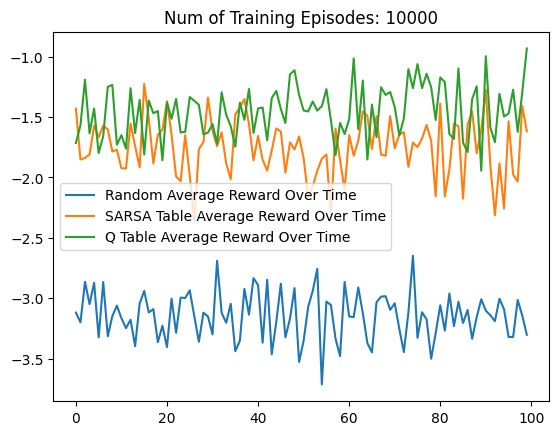

In [70]:
plt.plot(randomReward, label = 'Random Average Reward Over Time')
plt.plot(sRewards, label = 'SARSA Table Average Reward Over Time')
plt.plot(qRewards, label = 'Q Table Average Reward Over Time')

plt.legend()
plt.title(f"Num of Training Episodes: {numEpisodes}")

plt.show()

This looks great! Now let's start to expand a little bit.
* Time steps per episode: 6 -> 10     
  - Increases amount of time to equal the number of tasks, so theoretically everything could get done under indeal circumstances
* Energy range per episode: [30,35] -> [45,50]
  - Increasing the amount of energy per episode to increase the potential for the agent to complete all of the tasks
* Number of training episodes: 10,000 -> 50,000
  - I need to increase the number of training episodes to account for the increase in state space/table size
* Gamma: .9 -> .97
  - Increase in gamma to help with long term prioritization

In [71]:
from datetime import time
import matplotlib.pyplot as plt
import numpy as np

numEpisodes = 50000
eps = 1
epsDecay = 0.99994
alpha = .01
gamma = .97
seed = 400
minStartEnergy = 45
maxStartEnergy = 50
timePerEp = 10
tasksCsv = 'tasks.csv.csv'

random.seed(seed)

randomReward = []
randomTasksCompleted = []
for j in range(100):
    innerRandomReward = []
    innerRandomTasksCompleted = []
    #Getting a random to compare it to!
    for i in range(100):
        env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = env.getStartState()
        action = random.randint(0,9)
        totalReward = 0
        while state is not None:
            reward, nextState = env.updateAction(action)
            totalReward += reward
            nextAction = random.randint(0,9)
            state = nextState
            action = nextAction
        innerRandomReward.append(totalReward)
        innerRandomTasksCompleted.append(env.tasksDone.count(1))
    randomReward.append(np.mean(innerRandomReward))
    randomTasksCompleted.append(np.mean(innerRandomTasksCompleted))




#Training SARSA
random.seed(seed)
sTableee = SARSATable(num_actions = 10, alpha=alpha, gamma=gamma)
eps = 1
for i in range(numEpisodes):
    env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
    state = env.getStartState()
    action = sTableee.choose_action(state, eps)
    while state is not None:
        reward, nextState = env.updateAction(action)

        if nextState is None:
            sTableee.update_terminal(state, action, reward)
            break

        nextAction = sTableee.choose_action(nextState, eps)
        sTableee.update_sarsa(state, action, reward, nextState, nextAction)
        state = nextState
        action = nextAction
    eps = max(epsDecay * eps, .05)

#Training Q
random.seed(seed)
qTableee = QTable(num_actions = 10, alpha=alpha, gamma=gamma)
eps = 1
for i in range(numEpisodes):
    env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
    state = env.getStartState()
    while state is not None:
        action = qTableee.choose_action(state, eps)
        reward, nextState = env.updateAction(action)

        if nextState is None:
            qTableee.update_terminal(state, action, reward)
            break

        qTableee.update_q(state, action, reward, nextState)
        state = nextState
    eps = max(epsDecay * eps, .05)

#Evaluation SARSA
random.seed(seed)
eps = 0
sRewards = []
sTasksCompleted = []
for j in range(100):
    innerSRewards = []
    innerSTasksCompleted = []
    for i in range(100):
        env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = env.getStartState()
        action = sTableee.choose_action(state, eps)
        totalReward = 0
        while state is not None:
            reward, nextState = env.updateAction(action)
            totalReward += reward

            if nextState is None:
                sTableee.update_terminal(state, action, reward)
                break

            nextAction = sTableee.choose_action(nextState, eps)
            sTableee.update_sarsa(state, action, reward, nextState, nextAction)
            state = nextState
            action = nextAction
        innerSRewards.append(totalReward)
        innerSTasksCompleted.append(env.tasksDone.count(1))
    sRewards.append(np.mean(innerSRewards))
    sTasksCompleted.append(np.mean(innerSTasksCompleted))

#Evaluation Q
random.seed(seed)
eps = 0
qRewards = []
qTasksCompleted = []
for j in range(100):
    innerQRewards = []
    innerQTasksCompleted = []
    for i in range(100):
        env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = env.getStartState()
        totalReward = 0
        while state is not None:
            action = qTableee.choose_action(state, eps)
            reward, nextState = env.updateAction(action)
            totalReward += reward

            if nextState is None:
                qTableee.update_terminal(state, action, reward)
                break

            qTableee.update_q(state, action, reward, nextState)
            state = nextState
        innerQRewards.append(totalReward)
        innerQTasksCompleted.append(env.tasksDone.count(1))
    qRewards.append(np.mean(innerQRewards))
    qTasksCompleted.append(np.mean(innerQTasksCompleted))

In [72]:
print(f"Average random reward: {np.mean(randomReward)}")
print(f"Average tasks completed for random: {np.mean(randomTasksCompleted)}/10")
print()

print(f"SARSA Table average reward: {np.mean(sRewards)}")
print(f"SARSA Table average tasks completed: {np.mean(sTasksCompleted)}/10")
print()

print(f"Q Table average reward: {np.mean(qRewards)}")
print(f"Q Table average tasks completed: {np.mean(qTasksCompleted)}/10")
print()

Average random reward: -9.557401630118578
Average tasks completed for random: 7.047299999999999/10

SARSA Table average reward: -4.563544322535264
SARSA Table average tasks completed: 8.0705/10

Q Table average reward: -4.287903894959428
Q Table average tasks completed: 7.9909/10



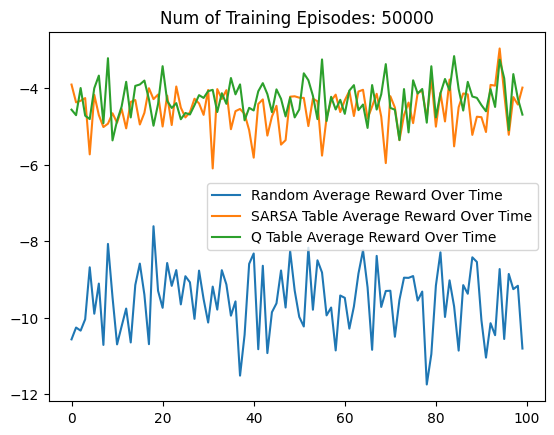

In [73]:
plt.plot(randomReward, label = 'Random Average Reward Over Time')
plt.plot(sRewards, label = 'SARSA Table Average Reward Over Time')
plt.plot(qRewards, label = 'Q Table Average Reward Over Time')

plt.legend()
plt.title(f"Num of Training Episodes: {numEpisodes}")

plt.show()

So this looks pretty okay... but not as great as my previous rewards. It would require a lot more training time to get great results from these tables due to the increased state space.

Because of this, I would like to try a different type of learner that can more easily adapt to a more expansive state space. Especially since I eventually want to be able to dump a semester's worth of assignments in here (theoretically) and right now doing that would blow up my state space.

Enter the Q-Net

In [74]:
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, state):
        return self.net(state)


Q-Nets have the following advantages:
* Generalizes to the situation, not just learning hyper-specific situations
* Reuses past experience better
* Recognizes similar states should probably do similar things
* Smooths out noise easier

For a Q-Net I have to adjust the format of the state to better train in a Q-Net. In particular, I need to make it so that my `tasks_done` is represented as a vector of 1s and 0s instead of an integer. I'm also going to one-hot-encode the `current_category` variable as well.

In order to train the Q-Net properly, we're also going to need a replay buffer.

In [75]:
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, done):
        self.buffer.append((s, a, r, s2, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, done = zip(*batch)
        return np.array(s), np.array(a), np.array(r), np.array(s2), np.array(done)

    def __len__(self):
        return len(self.buffer)


In [76]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

numEpisodes = 50000
alpha = .01
gamma = .97
seed = 400
eps = 1
epsDecay = .00002375
minStartEnergy = 45
maxStartEnergy = 50
timePerEp = 10
tasksCsv = 'tasks.csv.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Training DQN
random.seed(seed)
qNet = DQN(19, 10)
qNet = qNet.to(device)
targetNet = DQN(19, 10)
targetNet = targetNet.to(device)
targetNet.load_state_dict(qNet.state_dict())
replay = ReplayBuffer()
batchSize = 64
updateFrequ = 500
totalSteps = 0
optimizer = torch.optim.Adam(qNet.parameters(), lr = alpha)
losses = []

for e in range(numEpisodes):
    # print(f"\nEpisode: {e}")
    currEnv = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
    state = currEnv.getStartState(dqn = True)
    done = 0
    while done != 1:
        if random.random() < eps:
            # only choose from not-done tasks
            action = random.randint(0,len(currEnv.tasksDone)-1)
            while currEnv.tasksDone[action] == 1:
                action = random.randint(0,len(currEnv.tasksDone)-1)
        else:
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            s = s.to(device)
            qVals = qNet(s)[0]
            for i,d in enumerate(currEnv.tasksDone):
                if d == 1:
                    qVals[i] = -1e9  # mask via big negative
            action = torch.argmax(qVals).item()


        reward, nextState, done = currEnv.updateAction(action=action, dqn = True)
        replay.push(state, action, reward, nextState, done)
        if len(replay) > batchSize and totalSteps % 4 == 0:
            states, actions, rewards, next_states, dones = replay.sample(batchSize)
            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.long).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)

            qVals = qNet(states)
            qPred = qVals.gather(1, actions.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                qNext = targetNet(next_states)
                maxNext = qNext.max(dim=1)[0]
                qTargetVals = rewards + (1-dones) * gamma * maxNext

            loss = F.mse_loss(qPred, qTargetVals)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if totalSteps % updateFrequ == 0:
            # print(f"Total Steps so far: {totalSteps}")
            targetNet.load_state_dict(qNet.state_dict())

        state = nextState
        totalSteps += 1

    eps = max(.05, eps - epsDecay)

#Evaluation QNet
random.seed(seed)
eps = 0
qNet.eval()
qNetRewards = []
qNetTasksCompleted = []
for j in range(100):
    innerQNetRewards = []
    innerQNetTasksCompleted = []
    for i in range(100):
        print(f"\nEpisode: {j}.{i}")
        currEnv = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = currEnv.getStartState(dqn = True)
        totalReward = 0
        done = 0
        while done != 1:
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            s = s.to(device)
            qVals = qNet(s)[0]
            for i,d in enumerate(currEnv.tasksDone):
                if d == 1:
                    qVals[i] = -1e9  # mask via big negative
            action = torch.argmax(qVals).item()
            reward, nextState, done = currEnv.updateAction(action=action, dqn = True)
            state = nextState
            totalReward += reward

        innerQNetRewards.append(totalReward)
        innerQNetTasksCompleted.append(currEnv.tasksDone.count(1))
    qNetRewards.append(np.mean(innerQNetRewards))
    qNetTasksCompleted.append(np.mean(innerQNetTasksCompleted))

Streaming output truncated to the last 5000 lines.

Episode: 75.0

Episode: 75.1

Episode: 75.2

Episode: 75.3

Episode: 75.4

Episode: 75.5

Episode: 75.6

Episode: 75.7

Episode: 75.8

Episode: 75.9

Episode: 75.10

Episode: 75.11

Episode: 75.12

Episode: 75.13

Episode: 75.14

Episode: 75.15

Episode: 75.16

Episode: 75.17

Episode: 75.18

Episode: 75.19

Episode: 75.20

Episode: 75.21

Episode: 75.22

Episode: 75.23

Episode: 75.24

Episode: 75.25

Episode: 75.26

Episode: 75.27

Episode: 75.28

Episode: 75.29

Episode: 75.30

Episode: 75.31

Episode: 75.32

Episode: 75.33

Episode: 75.34

Episode: 75.35

Episode: 75.36

Episode: 75.37

Episode: 75.38

Episode: 75.39

Episode: 75.40

Episode: 75.41

Episode: 75.42

Episode: 75.43

Episode: 75.44

Episode: 75.45

Episode: 75.46

Episode: 75.47

Episode: 75.48

Episode: 75.49

Episode: 75.50

Episode: 75.51

Episode: 75.52

Episode: 75.53

Episode: 75.54

Episode: 75.55

Episode: 75.56

Episode: 75.57

Episode: 75.58

Episode: 75.59

In [77]:
print(f"Average random reward: {np.mean(randomReward)}")
print(f"Average tasks completed for random: {np.mean(randomTasksCompleted)}/10")
print()

print(f"SARSA Table average reward: {np.mean(sRewards)}")
print(f"SARSA Table average tasks completed: {np.mean(sTasksCompleted)}/10")
print()

print(f"Q Table average reward: {np.mean(qRewards)}")
print(f"Q Table average tasks completed: {np.mean(qTasksCompleted)}/10")
print()

print(f"Q Net average reward: {np.mean(qNetRewards)}")
print(f"Q Net average tasks completed: {np.mean(qNetTasksCompleted)}/10")
print()

Average random reward: -9.557401630118578
Average tasks completed for random: 7.047299999999999/10

SARSA Table average reward: -4.563544322535264
SARSA Table average tasks completed: 8.0705/10

Q Table average reward: -4.287903894959428
Q Table average tasks completed: 7.9909/10

Q Net average reward: -0.8230436340916144
Q Net average tasks completed: 8.977400000000003/10



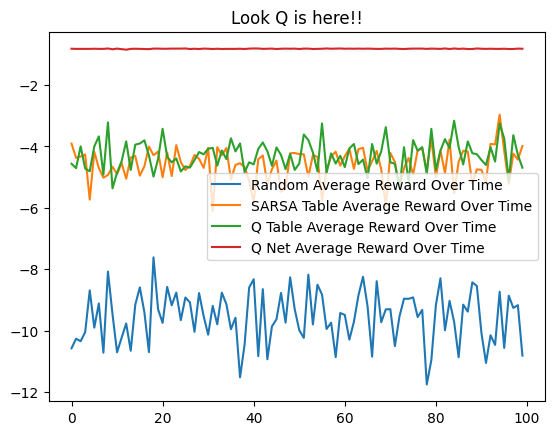

In [78]:
plt.plot(randomReward, label = 'Random Average Reward Over Time')
plt.plot(sRewards, label = 'SARSA Table Average Reward Over Time')
plt.plot(qRewards, label = 'Q Table Average Reward Over Time')
plt.plot(qNetRewards, label = 'Q Net Average Reward Over Time')

plt.legend()
plt.title(f"Look Q is here!!")

plt.show()

To kind of show scalability, I am going to start with just adding 10 more tasks, effectively blowing up my state space… by about 2<sup>10</sup> times.


In [23]:
from datetime import time
import matplotlib.pyplot as plt
import numpy as np

numEpisodes = 50000
eps = 1
epsDecay = 0.99994
alpha = .01
gamma = .97
seed = 400
minStartEnergy = 45
maxStartEnergy = 50
timePerEp = 10
tasksCsv = 'tasks2.csv'

random.seed(seed)

randomReward = []
randomTasksCompleted = []
for j in range(100):
    innerRandomReward = []
    innerRandomTasksCompleted = []
    #Getting a random to compare it to!
    for i in range(100):
        env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = env.getStartState()
        action = random.randint(0,19)
        totalReward = 0
        while state is not None:
            reward, nextState = env.updateAction(action)
            totalReward += reward
            nextAction = random.randint(0,19)
            state = nextState
            action = nextAction
        innerRandomReward.append(totalReward)
        innerRandomTasksCompleted.append(env.tasksDone.count(1))
    randomReward.append(np.mean(innerRandomReward))
    randomTasksCompleted.append(np.mean(innerRandomTasksCompleted))




#Training SARSA
random.seed(seed)
sTableee = SARSATable(num_actions = 10, alpha=alpha, gamma=gamma)
eps = 1
for i in range(numEpisodes):
    env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
    state = env.getStartState()
    action = sTableee.choose_action(state, eps)
    while state is not None:
        reward, nextState = env.updateAction(action)

        if nextState is None:
            sTableee.update_terminal(state, action, reward)
            break

        nextAction = sTableee.choose_action(nextState, eps)
        sTableee.update_sarsa(state, action, reward, nextState, nextAction)
        state = nextState
        action = nextAction
    eps = max(epsDecay * eps, .05)

#Training Q
random.seed(seed)
qTableee = QTable(num_actions = 10, alpha=alpha, gamma=gamma)
eps = 1
for i in range(numEpisodes):
    env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
    state = env.getStartState()
    while state is not None:
        action = qTableee.choose_action(state, eps)
        reward, nextState = env.updateAction(action)

        if nextState is None:
            qTableee.update_terminal(state, action, reward)
            break

        qTableee.update_q(state, action, reward, nextState)
        state = nextState
    eps = max(epsDecay * eps, .05)

#Evaluation SARSA
random.seed(seed)
eps = 0
sRewards = []
sTasksCompleted = []
for j in range(100):
    innerSRewards = []
    innerSTasksCompleted = []
    for i in range(100):
        env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = env.getStartState()
        action = sTableee.choose_action(state, eps)
        totalReward = 0
        while state is not None:
            reward, nextState = env.updateAction(action)
            totalReward += reward

            if nextState is None:
                sTableee.update_terminal(state, action, reward)
                break

            nextAction = sTableee.choose_action(nextState, eps)
            sTableee.update_sarsa(state, action, reward, nextState, nextAction)
            state = nextState
            action = nextAction
        innerSRewards.append(totalReward)
        innerSTasksCompleted.append(env.tasksDone.count(1))
    sRewards.append(np.mean(innerSRewards))
    sTasksCompleted.append(np.mean(innerSTasksCompleted))

#Evaluation Q
random.seed(seed)
eps = 0
qRewards = []
qTasksCompleted = []
for j in range(100):
    innerQRewards = []
    innerQTasksCompleted = []
    for i in range(100):
        env = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = env.getStartState()
        totalReward = 0
        while state is not None:
            action = qTableee.choose_action(state, eps)
            reward, nextState = env.updateAction(action)
            totalReward += reward

            if nextState is None:
                qTableee.update_terminal(state, action, reward)
                break

            qTableee.update_q(state, action, reward, nextState)
            state = nextState
        innerQRewards.append(totalReward)
        innerQTasksCompleted.append(env.tasksDone.count(1))
    qRewards.append(np.mean(innerQRewards))
    qTasksCompleted.append(np.mean(innerQTasksCompleted))

In [24]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

numEpisodes = 50000
alpha = .01
gamma = .97
seed = 400
eps = 1
epsDecay = .00002375
minStartEnergy = 45
maxStartEnergy = 50
timePerEp = 10
tasksCsv = 'tasks2.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Training DQN
random.seed(seed)
qNet = DQN(29, 20)
qNet = qNet.to(device)
targetNet = DQN(29, 20)
targetNet = targetNet.to(device)
targetNet.load_state_dict(qNet.state_dict())
replay = ReplayBuffer()
batchSize = 64
updateFrequ = 500
totalSteps = 0
optimizer = torch.optim.Adam(qNet.parameters(), lr = alpha)
losses = []

for e in range(numEpisodes):
    # print(f"\nEpisode: {e}")
    currEnv = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
    state = currEnv.getStartState(dqn = True)
    done = 0
    while done != 1:
        if random.random() < eps:
            # only choose from not-done tasks
            action = random.randint(0,len(currEnv.tasksDone)-1)
            while currEnv.tasksDone[action] == 1:
                action = random.randint(0,len(currEnv.tasksDone)-1)
        else:
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            s = s.to(device)
            qVals = qNet(s)[0]
            for i,d in enumerate(currEnv.tasksDone):
                if d == 1:
                    qVals[i] = -1e9  # mask via big negative
            action = torch.argmax(qVals).item()


        reward, nextState, done = currEnv.updateAction(action=action, dqn = True)
        replay.push(state, action, reward, nextState, done)
        if len(replay) > batchSize and totalSteps % 4 == 0:
            states, actions, rewards, next_states, dones = replay.sample(batchSize)
            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.long).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)

            qVals = qNet(states)
            qPred = qVals.gather(1, actions.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                qNext = targetNet(next_states)
                maxNext = qNext.max(dim=1)[0]
                qTargetVals = rewards + (1-dones) * gamma * maxNext

            loss = F.mse_loss(qPred, qTargetVals)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if totalSteps % updateFrequ == 0:
            # print(f"Total Steps so far: {totalSteps}")
            targetNet.load_state_dict(qNet.state_dict())

        state = nextState
        totalSteps += 1

    eps = max(.05, eps - epsDecay)

#Evaluation QNet
random.seed(seed)
eps = 0
qNet.eval()
qNetRewards = []
qNetTasksCompleted = []
for j in range(100):
    innerQNetRewards = []
    innerQNetTasksCompleted = []
    for i in range(100):
        print(f"\nEpisode: {j}.{i}")
        currEnv = Environment(minStartEnergy, maxStartEnergy, timePerEp, tasksCsv)
        state = currEnv.getStartState(dqn = True)
        totalReward = 0
        done = 0
        while done != 1:
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            s = s.to(device)
            qVals = qNet(s)[0]
            for i,d in enumerate(currEnv.tasksDone):
                if d == 1:
                    qVals[i] = -1e9  # mask via big negative
            action = torch.argmax(qVals).item()
            reward, nextState, done = currEnv.updateAction(action=action, dqn = True)
            state = nextState
            totalReward += reward

        innerQNetRewards.append(totalReward)
        innerQNetTasksCompleted.append(currEnv.tasksDone.count(1))
    qNetRewards.append(np.mean(innerQNetRewards))
    qNetTasksCompleted.append(np.mean(innerQNetTasksCompleted))

Streaming output truncated to the last 5000 lines.

Episode: 75.0

Episode: 75.1

Episode: 75.2

Episode: 75.3

Episode: 75.4

Episode: 75.5

Episode: 75.6

Episode: 75.7

Episode: 75.8

Episode: 75.9

Episode: 75.10

Episode: 75.11

Episode: 75.12

Episode: 75.13

Episode: 75.14

Episode: 75.15

Episode: 75.16

Episode: 75.17

Episode: 75.18

Episode: 75.19

Episode: 75.20

Episode: 75.21

Episode: 75.22

Episode: 75.23

Episode: 75.24

Episode: 75.25

Episode: 75.26

Episode: 75.27

Episode: 75.28

Episode: 75.29

Episode: 75.30

Episode: 75.31

Episode: 75.32

Episode: 75.33

Episode: 75.34

Episode: 75.35

Episode: 75.36

Episode: 75.37

Episode: 75.38

Episode: 75.39

Episode: 75.40

Episode: 75.41

Episode: 75.42

Episode: 75.43

Episode: 75.44

Episode: 75.45

Episode: 75.46

Episode: 75.47

Episode: 75.48

Episode: 75.49

Episode: 75.50

Episode: 75.51

Episode: 75.52

Episode: 75.53

Episode: 75.54

Episode: 75.55

Episode: 75.56

Episode: 75.57

Episode: 75.58

Episode: 75.59

In [25]:
print(f"Average random reward: {np.mean(randomReward)}")
print(f"Average tasks completed for random: {np.mean(randomTasksCompleted)}/10")
print()

print(f"SARSA Table average reward: {np.mean(sRewards)}")
print(f"SARSA Table average tasks completed: {np.mean(sTasksCompleted)}/10")
print()

print(f"Q Table average reward: {np.mean(qRewards)}")
print(f"Q Table average tasks completed: {np.mean(qTasksCompleted)}/10")
print()

print(f"Q Net average reward: {np.mean(qNetRewards)}")
print(f"Q Net average tasks completed: {np.mean(qNetTasksCompleted)}/10")
print()

Average random reward: -4.957570032717786
Average tasks completed for random: 7.343399999999998/10

SARSA Table average reward: -25.919371160715404
SARSA Table average tasks completed: 10.0/10

Q Table average reward: -25.797942578857587
Q Table average tasks completed: 10.0/10

Q Net average reward: -1.9541703181692973
Q Net average tasks completed: 10.0/10



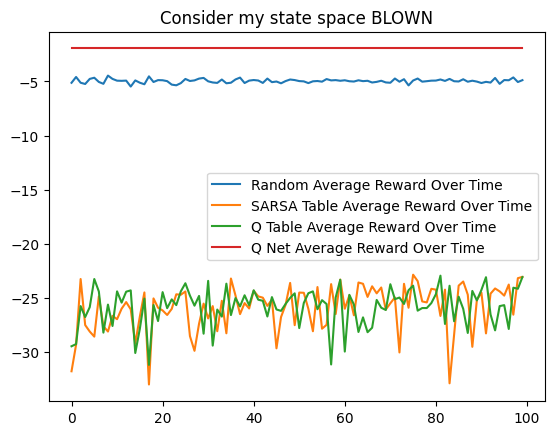

In [26]:
plt.plot(randomReward, label = 'Random Average Reward Over Time')
plt.plot(sRewards, label = 'SARSA Table Average Reward Over Time')
plt.plot(qRewards, label = 'Q Table Average Reward Over Time')
plt.plot(qNetRewards, label = 'Q Net Average Reward Over Time')

plt.legend()
plt.title(f"Consider my state space BLOWN")

plt.show()

Now that I’ve found something that I feel like works really well, I want to add deadlines to my project!

One of the big things about prioritizing tasks is that things are sometimes due before other things. So here’s what I'm thinking for this next step:
* About 70 tasks
* 50 time steps
* I'll probably increase energy to about 150 and make sure to add more “Rest” options
* There will be at least one assignment (as in a homework type assignment specifically) that is “due” every 3 time steps
  - If an assignment is due but hasn’t been completed, the penalty will be immediately applied and the agent will not be able to get any reward for completing it later
* At the end of the 50 time steps, all remaining penalties will be added as well

I don’t anticipate this really changing much about how the QNet performs, other than the state space is now much much much bigger, but I wanted to make sure I had something that could handle a situation this large before I did it.


In [27]:
#Example of tasks with deadlines
tasks = pd.read_csv('tasksFINALBOSS4rl.csv')
tasks

,Task Description,Category,Value,Difficulty,Energy Cost,Penalty,Deadline
0,Algorithm Practice,CS,7,6,10,-10.50,33
1,Attend Service,Religion,5,2,3,-2.50,0
2,Bake Something,Leisure,3,0,1,0.00,0
3,Bible Study,Religion,4,3,4,-3.00,0
4,Change Bed Sheets,Chores,2,1,2,-0.50,0
...,...,...,...,...,...,...,...
65,Weighted Blanket Time,Rest,0,-4,-4,0.00,0
66,Work on Capstone,CS,10,9,17,-22.50,45
67,Write Reflections,Religion,3,2,3,-1.50,0
68,Write Unit Tests,CS,5,3,4,-3.75,3


I also need to update my Environment and Tasks classes to handle this deadline functionality.

In [47]:
import random

class Environment():
    def __init__(self):
        #Creating all of my tasks
        self.tasksList = []
        norm = None
        with open("tasksFINALBOSS4rl.csv", 'r') as file:
            headers = file.readline()
            for line in file.readlines():
                elements = line.strip().split(',')
                self.tasksList.append(Task(elements[0], elements[1], elements[2], elements[4], elements[5], elements[6]))
                if norm is None or abs(int(elements[2])) > norm:
                    norm = abs(int(elements[2]))
                if abs(float(elements[5])) > norm:
                    norm = abs(float(elements[5]))

        self.tasksDone = [0 for i in range(len(self.tasksList))]
        self.energy = random.randint(148,152)
        self.distractionProbs = {'low':.1, 'medium':.25, 'high':.5}
        self.time_left = 50

        self.categoriesList = []
        for task in self.tasksList:
            task.normalizeValueAndPenalty(norm)
            if task.category not in self.categoriesList:
                self.categoriesList.append(task.category)

        self.currentCat = 'Rest'

    def updateAction(self, action, dqn = False):
        if self.time_left == 0:
            # print("We're done!")
            return None, None

        if self.tasksDone[action] == 1:
            # print('This task has already been done!')
            if not dqn:
                return -1, (self.energy, self.currentCat, self.todosToBits(), self.time_left)
            else:
                return -1, [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left], 0

        completedTask = self.tasksList[action]

        if self.currentCat == None or self.currentCat == 'Rest':
            risk = -1
        elif self.currentCat == completedTask.category:
            risk = self.distractionProbs['low']
        elif self.currentCat in ['CS','Stats','Work'] and completedTask.category in ['CS','Stats','Work']:
            risk = self.distractionProbs['medium']
        elif self.currentCat in ['Chores', 'Religion'] and completedTask.category in ['Chores', 'Religion']:
            risk = self.distractionProbs['medium']
        else:
            risk = self.distractionProbs['high']

        if self.energy - completedTask.energy_cost < 0:
            # print("You don't have enough energy for this task!")
            self.energy = 0
            self.time_left = 0
            penalities = self.getEndPenalties()
            if not dqn:
                return -1 + penalities, None
            else:
                return -1 + penalities, [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left], 1


        self.energy -= completedTask.energy_cost
        distractionNoise = random.randint(1,5)
        if random.uniform(0,1) <= risk:
            self.energy = max(self.energy - distractionNoise, 0)

        self.currentCat = completedTask.category
        self.tasksDone[action] = 1
        for i in range(len(self.tasksList)):
            if self.tasksDone[i] == 0:
                self.tasksList[i].updateValue()
        self.time_left -= 1


        if self.time_left == 0:
            if not dqn:
                return self.getEndPenalties() + completedTask.value, None
            else:
                return self.getEndPenalties() + completedTask.value, [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left], 1
        else:
            if not dqn:
                return completedTask.value + self.getMidPenalties(), (self.energy, self.currentCat, self.todosToBits(), self.time_left)
            else:
                return completedTask.value + self.getMidPenalties(), [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left], 0


    def todosToBits(self):
        bitmask = int("".join(map(str, self.tasksDone)), 2)
        return bitmask

    def getEndPenalties(self):
        pen = 0
        for i in range(len(self.tasksDone)):
            if self.tasksDone[i] == 0:
                pen += self.tasksList[i].penalty
        return pen

    def getStartState(self, dqn = False):
        if not dqn:
            return (self.energy, self.currentCat, self.todosToBits(), self.time_left)
        else:
            return [self.energy] + [0 if cate != self.currentCat else 1 for cate in self.categoriesList] + self.tasksDone + [self.time_left]

    def setEnergy(self, energy):
        self.energy = energy

    def getMidPenalties(self):
      pen = 0
      for i in range(len(self.tasksDone)):
        if self.tasksList[i].deadline > self.time_left and self.tasksDone[i] == 0:
          pen += self.tasksList[i].penalty
          self.tasksList[i].penalty = 0 #Don't need to double count penalty!! Haha.
          self.tasksList[i].value = 0
      return pen

In [48]:
class Task():
    def __init__(self, name, category, value, energy_cost, penalty, deadline):
        self.name = name
        self.category = category
        self.value = int(value)
        self.energy_cost = int(energy_cost)
        self.penalty = float(penalty)
        self.deadline = int(deadline)

    def updateValue(self):
        self.value *= .9862

    def normalizeValueAndPenalty(self, norm):
        self.value /= norm
        self.penalty /= norm

    def __str__(self):
        return f"{self.name} has a value of {self.value} and a cost of {self.energy_cost}."

In [52]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

numEpisodes = 50000
alpha = .01
gamma = .97
seed = 400
eps = 1
epsDecay = .00002375
minStartEnergy = 148
maxStartEnergy = 152
timePerEp = 50
tasksCsv = 'tasksFINALBOSS4rl.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Training DQN
random.seed(seed)
currEnv = Environment()
state = currEnv.getStartState(dqn = True)
qNet = DQN(len(state), len(currEnv.tasksDone))
qNet = qNet.to(device)
targetNet = DQN(len(state), len(currEnv.tasksDone))
targetNet = targetNet.to(device)
targetNet.load_state_dict(qNet.state_dict())
replay = ReplayBuffer()
batchSize = 64
updateFrequ = 500
totalSteps = 0
optimizer = torch.optim.Adam(qNet.parameters(), lr = alpha)
losses = []

for e in range(numEpisodes):
    # print(f"\nEpisode: {e}")
    currEnv = Environment()
    state = currEnv.getStartState(dqn = True)
    done = 0
    while done != 1:
        if random.random() < eps:
            # only choose from not-done tasks
            action = random.randint(0,len(currEnv.tasksDone)-1)
            while currEnv.tasksDone[action] == 1:
                action = random.randint(0,len(currEnv.tasksDone)-1)
        else:
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            s = s.to(device)
            qVals = qNet(s)[0]
            for i,d in enumerate(currEnv.tasksDone):
                if d == 1:
                    qVals[i] = -1e9  # mask via big negative
            action = torch.argmax(qVals).item()


        reward, nextState, done = currEnv.updateAction(action=action, dqn = True)
        replay.push(state, action, reward, nextState, done)
        if len(replay) > batchSize and totalSteps % 4 == 0:
            states, actions, rewards, next_states, dones = replay.sample(batchSize)
            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.long).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)

            qVals = qNet(states)
            qPred = qVals.gather(1, actions.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                qNext = targetNet(next_states)
                maxNext = qNext.max(dim=1)[0]
                qTargetVals = rewards + (1-dones) * gamma * maxNext

            loss = F.mse_loss(qPred, qTargetVals)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if totalSteps % updateFrequ == 0:
            # print(f"Total Steps so far: {totalSteps}")
            targetNet.load_state_dict(qNet.state_dict())

        state = nextState
        totalSteps += 1

    eps = max(.05, eps - epsDecay)

#Evaluation QNet
random.seed(seed)
eps = 0
qNet.eval()
qNetRewards = []
qNetTasksCompleted = []
for j in range(100):
    innerQNetRewards = []
    innerQNetTasksCompleted = []
    for i in range(100):
        # print(f"\nEpisode: {j}.{i}")
        currEnv = Environment()
        state = currEnv.getStartState(dqn = True)
        totalReward = 0
        done = 0
        while done != 1:
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            s = s.to(device)
            qVals = qNet(s)[0]
            for i,d in enumerate(currEnv.tasksDone):
                if d == 1:
                    qVals[i] = -1e9  # mask via big negative
            action = torch.argmax(qVals).item()
            reward, nextState, done = currEnv.updateAction(action=action, dqn = True)
            state = nextState
            totalReward += reward

        innerQNetRewards.append(totalReward)
        innerQNetTasksCompleted.append(currEnv.tasksDone.count(1))
    qNetRewards.append(np.mean(innerQNetRewards))
    qNetTasksCompleted.append(np.mean(innerQNetTasksCompleted))

In [53]:
print(f"Average random reward: {np.mean(randomReward)}")
print(f"Average tasks completed for random: {np.mean(randomTasksCompleted)}/50")
print()

print(f"Q Net average reward: {np.mean(qNetRewards)}")
print(f"Q Net average tasks completed: {np.mean(qNetTasksCompleted)}/50")
print()

Average random reward: -4.957570032717786
Average tasks completed for random: 7.343399999999998/50

Q Net average reward: -1.3905822125658653
Q Net average tasks completed: 33.3118/50



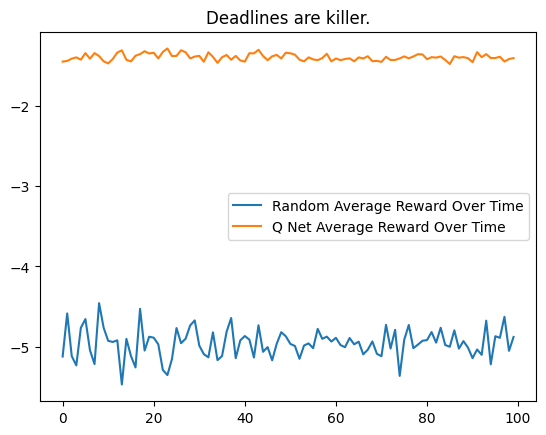

In [54]:
plt.plot(randomReward, label = 'Random Average Reward Over Time')
plt.plot(qNetRewards, label = 'Q Net Average Reward Over Time')

plt.legend()
plt.title(f"Deadlines are killer.")

plt.show()

Let's look at what this final policy ends up being! Keep in mind, an optimal policy would make sure to hit the following deadlines...

```
DL Lab, done by 48
Work on Capstone, done by 45
Final Projects, done by 42
Finish Programming Lab, done by 42
Paper Writing, done by 39
RL Homework, done by 36
Implement Feature, done by 33
Algorithm Practice, done by 33
Complete Stats Lab, done by 30
Create Presentation, done by 27
Refactor Codebase, done by 24
Stats Homework, done by 24
Debugging Session, done by 21
Review Probability Concepts, done by 18
Research, done by 18
Draft Report, done by 15
Research New Framework, done by 12
Study for Exam, done by 12
Stats Practice Problems, done by 9
DL Readings, done by 6
Meet With Team, done by 3
Study Stats Notes, done by 3
Write Unit Tests, done by 3
```

In [55]:
minStartEnergy = 148
maxStartEnergy = 152
timePerEp = 50
tasksCsv = 'tasksFINALBOSS4rl.csv'

finalEnv = Environment()
finalEnv.setEnergy(150)
finalState = finalEnv.getStartState(dqn = True)

print("Q NET")
QtotalReward = 0
done = 0
while done != 1:
    s = torch.tensor(finalState, dtype=torch.float32).unsqueeze(0).to(device)
    s = s.to(device)
    qVals = qNet(s)[0]
    for i,d in enumerate(finalEnv.tasksDone):
        if d == 1:
            qVals[i] = -1e9  # mask via big negative
    action = torch.argmax(qVals).item()
    print(finalEnv.tasksList[action].name)
    # print(finalEnv.tasksList[action].energy_cost)
    reward, finalState, done = finalEnv.updateAction(action, dqn = True)
    QtotalReward += reward
    # print()
print("\nDONE!!")
print(f"Number of tasks done: {np.count_nonzero(finalEnv.tasksDone)}")
print(f"Total reward: {QtotalReward}")

Q NET
Final Projects
Work on Capstone
Paper Writing
Implement Feature
Finish Programming Lab
Clean Bathroom
Research
Draft Report
Deep Breathing
Meditating
Complete Stats Lab
RL Homework
Attend Service
Sleeping
Take a Nap
Algorithm Practice
Research New Framework
Early Bedtime
Study for Exam
Stretching
Laundry
Refactor Codebase
Write Unit Tests
Take Out Trash
Rest Day
Religious Reading
Vacuum Living Room
Participate in Group Study
Meal Prep
Review Probability Concepts
Code Review
Bake Something
Weighted Blanket Time
Do a Puzzle
Pray
Grocery Shopping

DONE!!
Number of tasks done: 35
Total reward: -1.2310169802537358


It actually did pretty well! It didn't get all of the things done that needed to be done in time, but it tried at least. It really could be that the agent didn't have enough energy to actually do everything it needed to, so this is just as far as it got, but I'm not sure. It definitely didn't do all of the tasks that it could have since it only did 35 tasks and not 50, but the total reward is actually quite high compared to what it could be so clearly it's okay with the decisions it has made.